Activation=relu        , fixed point from rho=0 is rho*=1.000000, iter=334


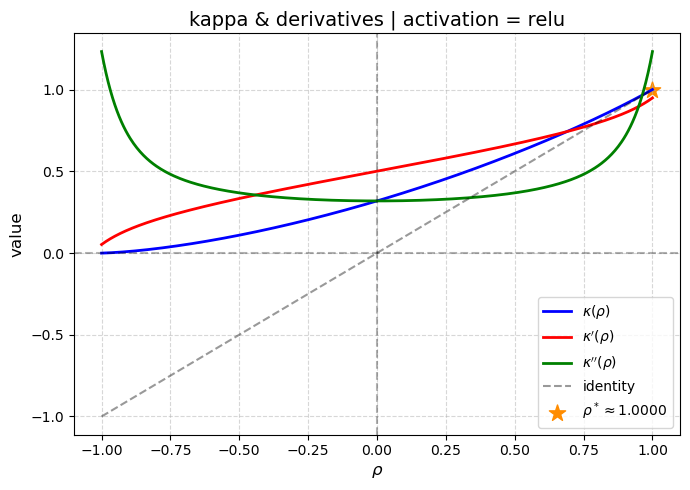

Activation=tanh        , fixed point from rho=0 is rho*=0.000000, iter=0


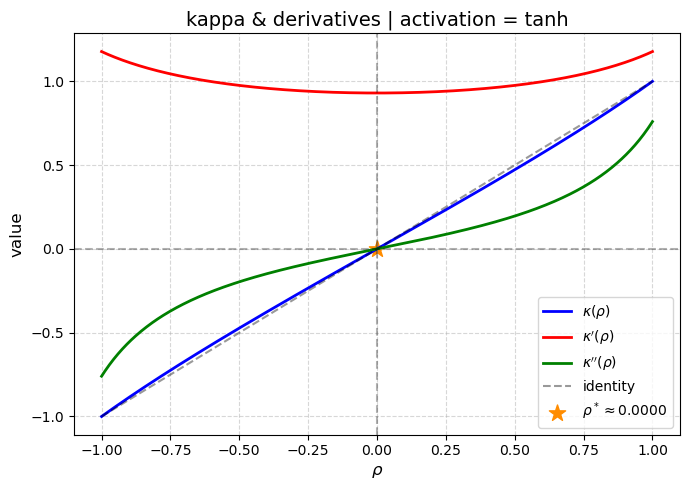

Activation=sigmoid     , fixed point from rho=0 is rho*=1.000000, iter=13


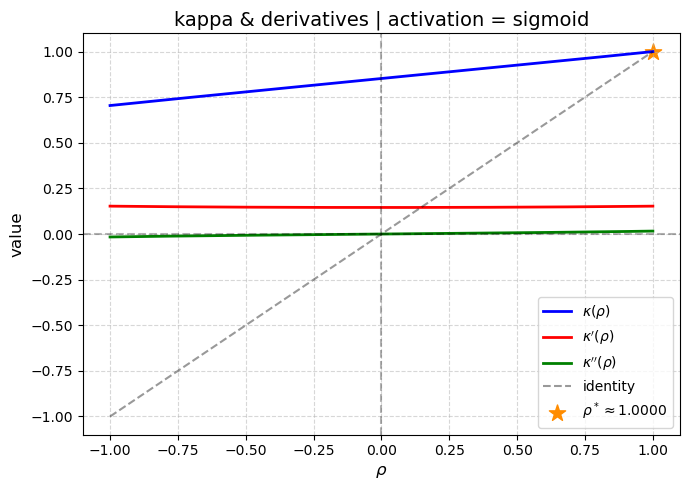

Activation=gelu        , fixed point from rho=0 is rho*=0.760260, iter=268


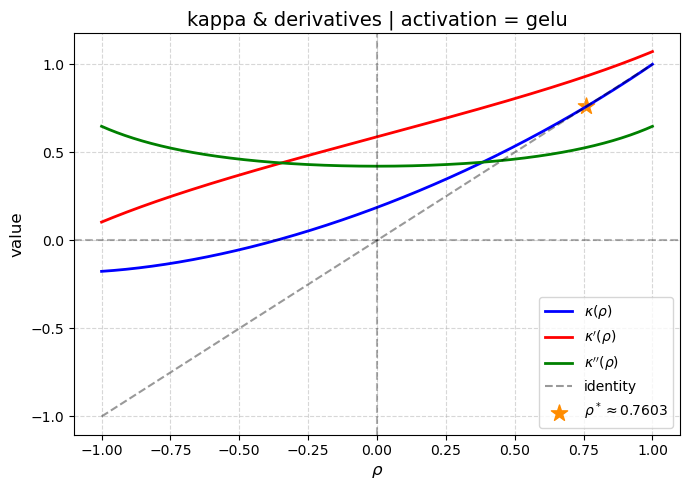

Activation=elu         , fixed point from rho=0 is rho*=0.597870, iter=592


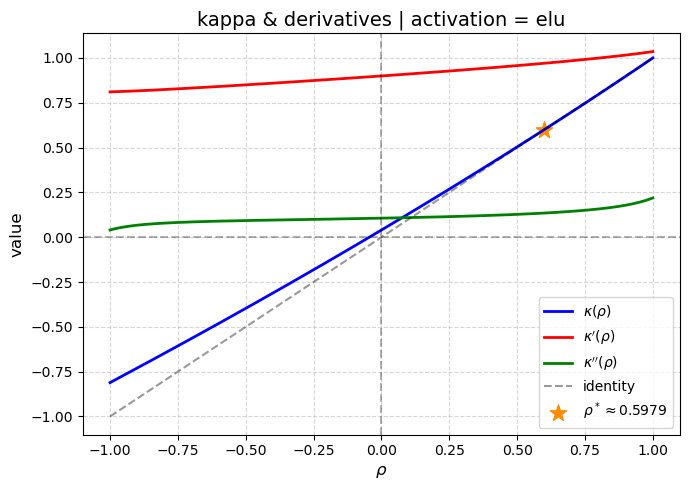

Activation=selu        , fixed point from rho=0 is rho*=0.000000, iter=0


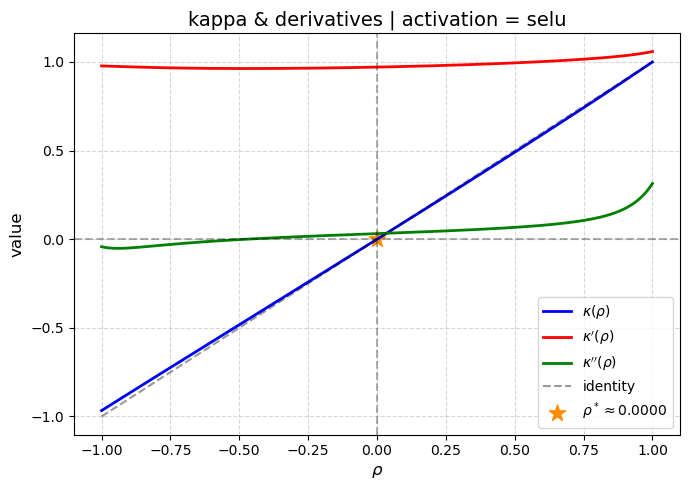

Activation=celu        , fixed point from rho=0 is rho*=0.597870, iter=592


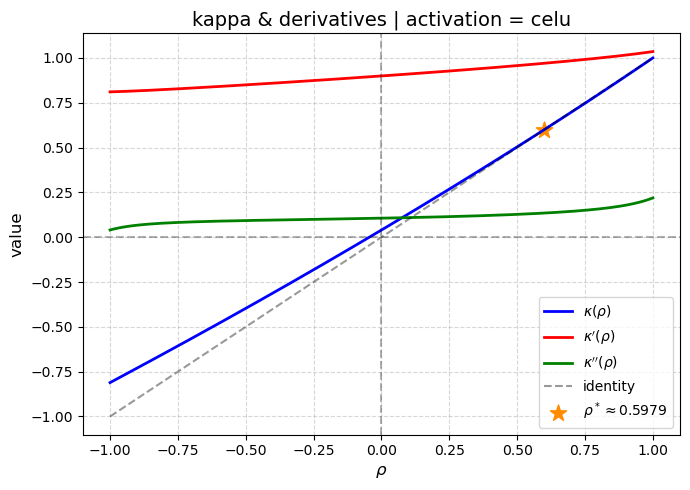

Activation=leaky_relu  , fixed point from rho=0 is rho*=1.000000, iter=535


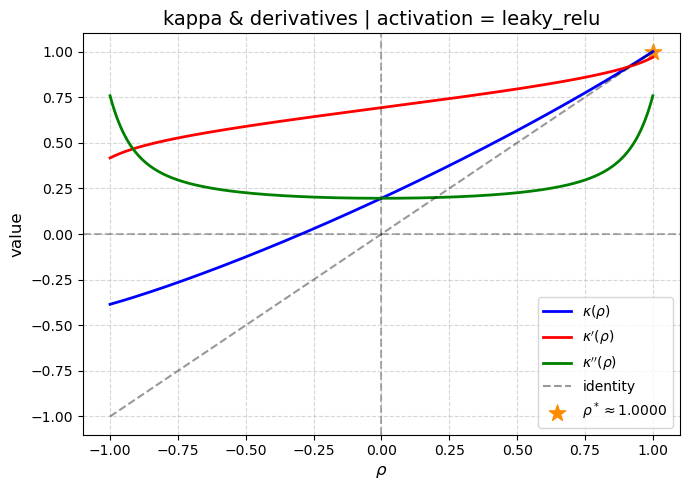

Activation=swish       , fixed point from rho=0 is rho*=0.658667, iter=281


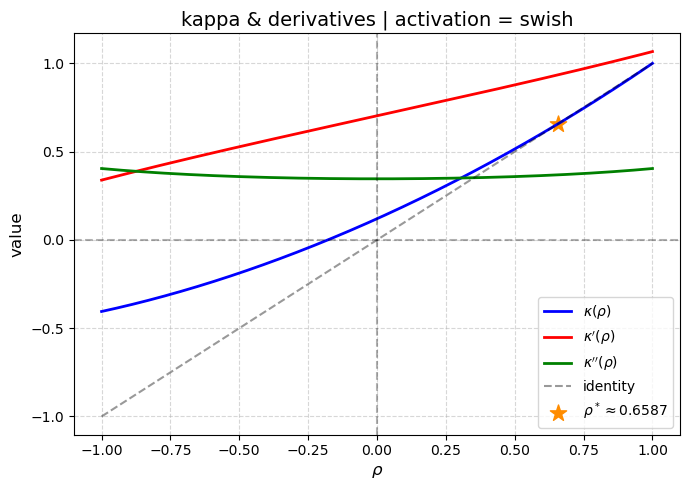

Activation=exp         , fixed point from rho=0 is rho*=0.999800, iter=10000


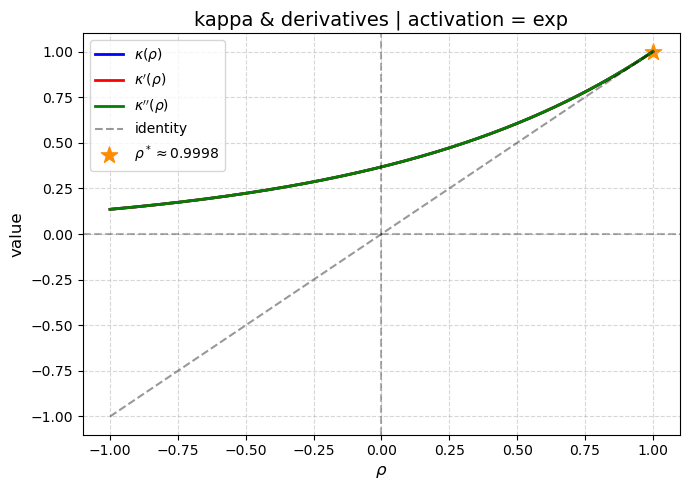

Activation=softplus    , fixed point from rho=0 is rho*=1.000000, iter=20


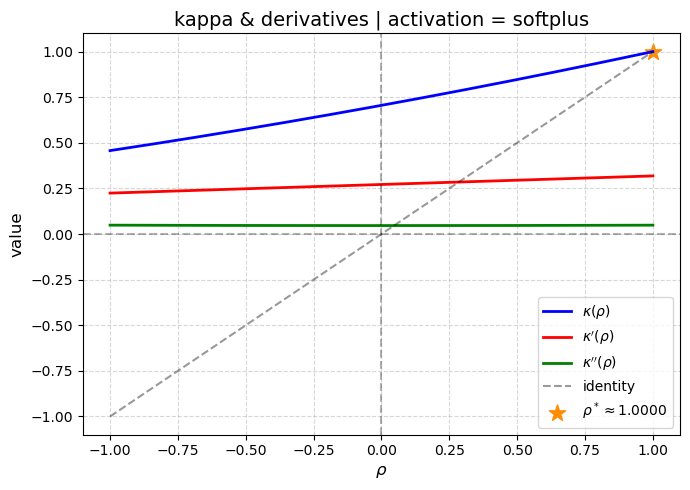

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import lru_cache
from scipy.integrate import quad
from scipy.special import hermitenorm

###############################################################################
# 1. Activation definition by name
###############################################################################
def get_activation_function(name):
    name = name.lower()

    if name == 'relu':
        return lambda x: np.maximum(0, x)
    elif name == 'tanh':
        return np.tanh
    elif name == 'sigmoid':
        return lambda x: 1 / (1 + np.exp(-x))
    elif name == 'gelu':
        # Approximate GELU
        return lambda x: 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi)*(x + 0.044715*x**3)))
    elif name == 'elu':
        alpha = 1.0
        return lambda x: np.where(x >= 0, x, alpha*(np.exp(x) - 1))
    elif name == 'selu':
        alpha = 1.6732632423543772
        scale = 1.0507009873554805
        return lambda x: scale * np.where(x >= 0, x, alpha*(np.exp(x) - 1))
    elif name == 'celu':
        alpha = 1.0
        return lambda x: np.where(x >= 0, x, alpha*(np.exp(x/alpha) - 1))
    elif name == 'leaky_relu':
        alpha = 0.2
        return lambda x: np.where(x >= 0, x, alpha*x)
    elif name == 'swish':
        return lambda x: x / (1.0 + np.exp(-x))
    elif name == 'exp':
        return np.exp
    elif name == 'softplus':
        return lambda x: np.log1p(np.exp(x))
    else:
        raise ValueError(f"Unknown or unimplemented activation: '{name}'")

###############################################################################
# 2. Hermite expansion & kernel map
###############################################################################
@lru_cache(maxsize=512)
def gaussian_pdf(x):
    """Standard Gaussian pdf."""
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def compute_hermite_coefs_integration(f, order=25, a=-10, b=10):
    """
    Numerically compute Hermite coefficients for function f:
       f(x) ~ sum_{k=0}^{order-1} c_k * He_k_normed(x),
    where He_k_normed(x) is the normalized (physicist) Hermite polynomial.
    """
    def he_k_normed(x, k):
        # Normalized Hermite polynomial: hermitenorm(k)(x) / sqrt(k!)
        return hermitenorm(k)(x) / math.sqrt(math.factorial(k))
    
    coefs = np.zeros(order, dtype=np.float64)
    
    for k in range(order):
        def integrand(xval):
            return f(xval) * he_k_normed(xval, k) * gaussian_pdf(xval)
        
        val, _ = quad(integrand, a, b, limit=200)
        coefs[k] = val
    return coefs

def kernel_map_from_coefs(coefs, deriv_order=0):
    """
    Returns a function for kappa^(n)(rho), the n-th derivative of kappa.
    If deriv_order=0 => kappa(rho)
       deriv_order=1 => kappa'(rho)
       deriv_order=2 => kappa''(rho), etc.

    In the normalized Hermite basis:
      kappa(rho)     = sum_{k=0}^{∞} [c_k^2 * rho^k]
      kappa'(rho)    = sum_{k=1}^{∞} [k * c_k^2 * rho^(k-1)]
      kappa''(rho)   = sum_{k=2}^{∞} [k*(k-1)* c_k^2 * rho^(k-2)], etc.

    We only do a finite sum up to len(coefs).
    """
    sq_coefs = coefs**2
    K = len(coefs)

    def falling_factorial(k, n):
        """Compute k*(k-1)*...*(k-n+1)."""
        val = 1
        for i in range(n):
            val *= (k - i)
        return val

    def kappa_nth_derivative(rho):
        val = 0.0
        for k in range(deriv_order, K):
            ff = falling_factorial(k, deriv_order)
            val += ff * sq_coefs[k] * (rho ** (k - deriv_order))
        return val

    return kappa_nth_derivative


###############################################################################
# 3. Fixed-point finder
###############################################################################
def find_fixed_point(kappa_func, rho_init=0.0, tol=1e-10, max_iter=10_000):
    """
    Iteratively find a fixed point of kappa_func, i.e. solve rho = kappa_func(rho).
    
    We do:
        rho_{n+1} = kappa_func(rho_n),
    starting from rho_init. If |rho_{n+1} - rho_n| < tol, we declare convergence.

    Returns: (rho_star, n_iter)
    """
    rho_current = rho_init
    for n in range(max_iter):
        rho_next = kappa_func(rho_current)
        if abs(rho_next - rho_current) < tol:
            return rho_next, n
        rho_current = rho_next
    # if no convergence, return last val anyway
    return rho_current, max_iter


###############################################################################
# 4. Main plotting function
###############################################################################
def plot_kappa_and_derivatives(activation_name, order=25):
    """Plot kappa, kappa', and kappa'' for the given activation in the range [-1,1],
       and mark the stable fixed point found by iteration from rho=0."""
    # 1) Get the activation
    f = get_activation_function(activation_name)
    
    # 2) Hermite coefficients
    coefs = compute_hermite_coefs_integration(f, order=order)
    
    # 3) Normalize so that E[phi(X)^2] = 1
    norm_factor = np.sqrt(np.sum(coefs**2))
    if norm_factor > 1e-12:
        coefs /= norm_factor
    
    # 4) Build kappa(rho), kappa'(rho), kappa''(rho)
    kappa        = kernel_map_from_coefs(coefs, deriv_order=0)
    kappa_prime  = kernel_map_from_coefs(coefs, deriv_order=1)
    kappa_dprime = kernel_map_from_coefs(coefs, deriv_order=2)
    
    # 5) Evaluate them on rho in [-1,1]
    rhos = np.linspace(-1, 1, 501)
    vals_kappa   = [kappa(r) for r in rhos]
    vals_kappa_p = [kappa_prime(r) for r in rhos]
    vals_kappa_pp= [kappa_dprime(r) for r in rhos]
    
    # 6) Find the stable fixed point starting from rho=0
    rho_star, n_iter = find_fixed_point(kappa, rho_init=0.0, tol=1e-10, max_iter=10_000)
    print(f"Activation={activation_name:12}, fixed point from rho=0 is rho*={rho_star:.6f}, iter={n_iter}")
    
    # 7) Plot
    plt.figure(figsize=(7,5))
    plt.plot(rhos, vals_kappa,   label=r'$\kappa(\rho)$',               color='blue',   lw=2)
    plt.plot(rhos, vals_kappa_p, label=r'$\kappa^{\prime}(\rho)$',      color='red',    lw=2)
    plt.plot(rhos, vals_kappa_pp,label=r'$\kappa^{\prime\prime}(\rho)$',color='green',  lw=2)
    
    # Identity line for reference
    plt.plot(rhos, rhos, 'k--', alpha=0.4, label='identity') 

    # Mark the discovered fixed point on the figure
    # If truly a fixed point, we have kappa(rho_star)=rho_star.
    if -1 <= rho_star <= 1:
        plt.scatter(rho_star, kappa(rho_star),
                    color='darkorange', s=150, marker='*',
                    label=rf'$\rho^* \approx {rho_star:.4f}$')

    plt.axhline(0, color='black', ls='--', alpha=0.3)
    plt.axvline(0, color='black', ls='--', alpha=0.3)

    plt.xlabel(r'$\rho$', fontsize=12)
    plt.ylabel('value',  fontsize=12)
    plt.title(f'kappa & derivatives | activation = {activation_name}', fontsize=14)
    plt.legend(loc='best')
    plt.grid(ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

###############################################################################
# 5. Run for multiple activations
###############################################################################
if __name__ == "__main__":
    activation_list = [
        "relu", "tanh", "sigmoid", "gelu", "elu", "selu",
        "celu", "leaky_relu", "swish", "exp", "softplus",
    ]
    
    for act in activation_list:
        try:
            plot_kappa_and_derivatives(act, order=25)
        except Exception as e:
            print(f"[Warning] Could not plot for {act}: {e}")


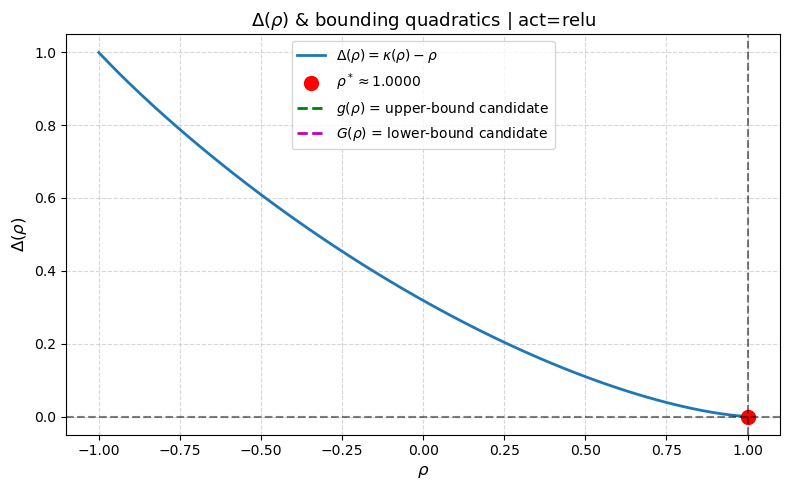

[relu]
   rho_star = 1.000000, Delta(rho_star) = 9.170442e-13 (should be ~0).
   f'(x_0)=-0.0513, f'(x_1)=-0.0513, alpha=0.0513, beta=0.0513



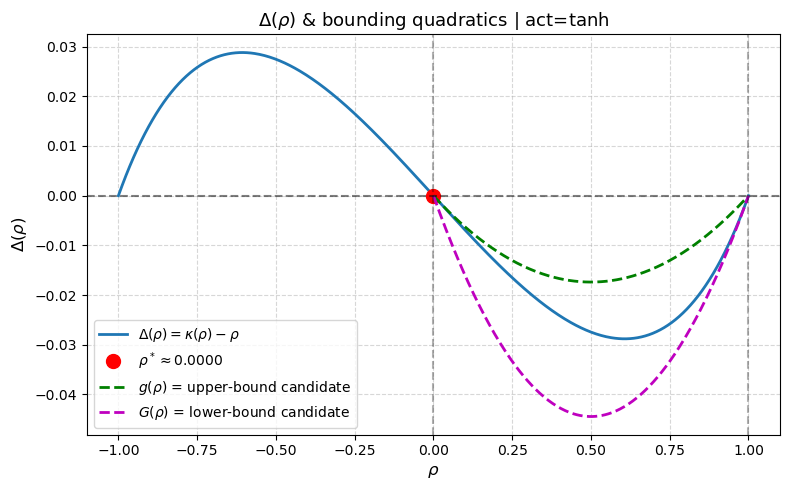

[tanh]
   rho_star = 0.000000, Delta(rho_star) = 0.000000e+00 (should be ~0).
   f'(x_0)=-0.0695, f'(x_1)=0.1777, alpha=0.0695, beta=0.1777



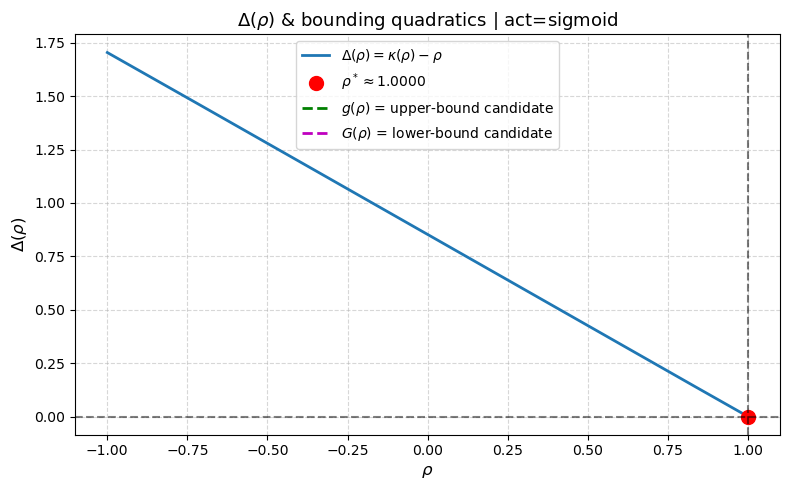

[sigmoid]
   rho_star = 1.000000, Delta(rho_star) = 7.216450e-14 (should be ~0).
   f'(x_0)=-0.8472, f'(x_1)=-0.8472, alpha=0.8472, beta=0.8472



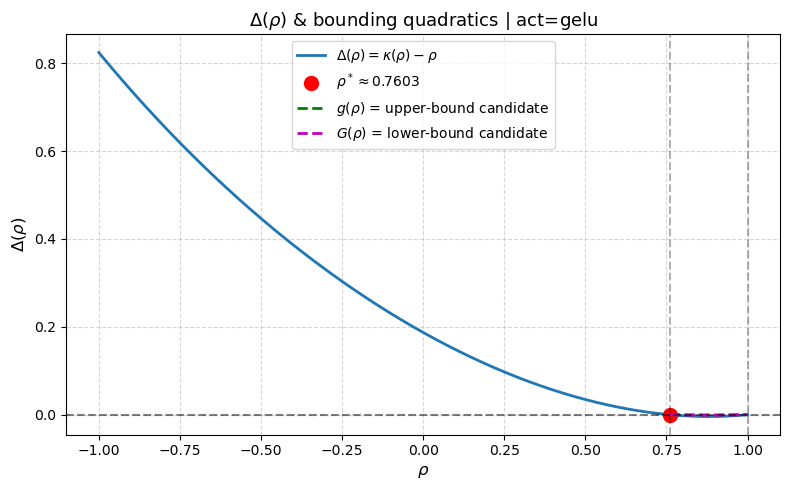

[gelu]
   rho_star = 0.760260, Delta(rho_star) = 8.825163e-13 (should be ~0).
   f'(x_0)=-0.0673, f'(x_1)=0.0720, alpha=0.0673, beta=0.0720



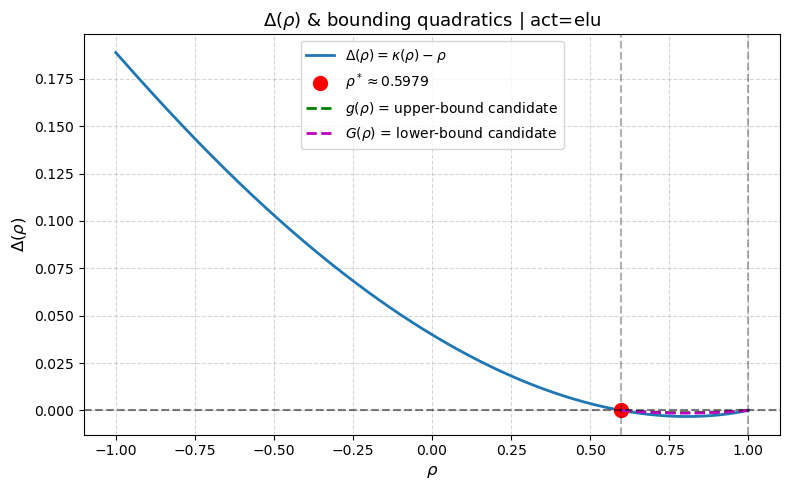

[elu]
   rho_star = 0.597870, Delta(rho_star) = 9.582335e-13 (should be ~0).
   f'(x_0)=-0.0302, f'(x_1)=0.0353, alpha=0.0302, beta=0.0353



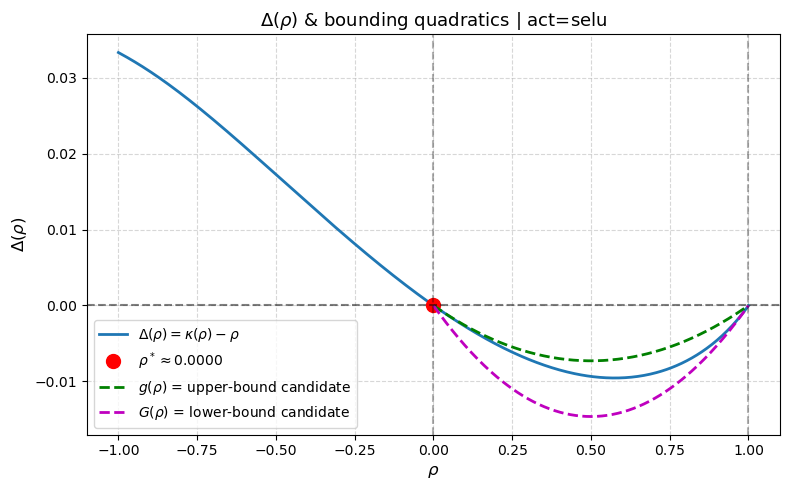

[selu]
   rho_star = 0.000000, Delta(rho_star) = 2.678710e-35 (should be ~0).
   f'(x_0)=-0.0291, f'(x_1)=0.0585, alpha=0.0291, beta=0.0585



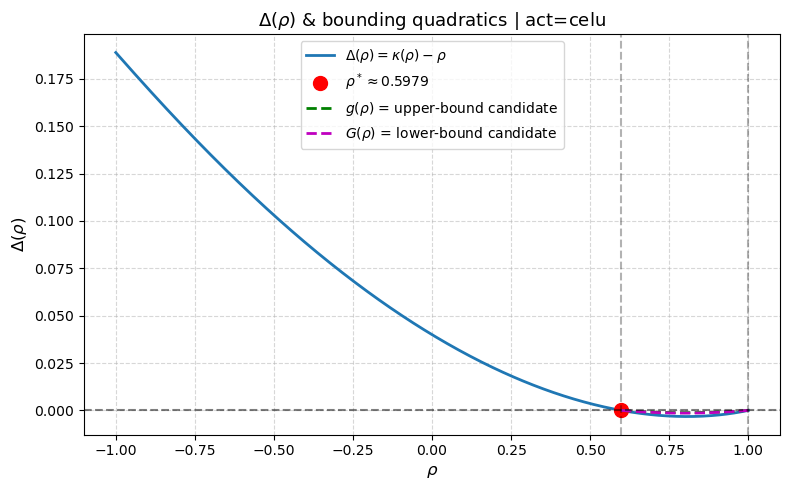

[celu]
   rho_star = 0.597870, Delta(rho_star) = 9.582335e-13 (should be ~0).
   f'(x_0)=-0.0302, f'(x_1)=0.0353, alpha=0.0302, beta=0.0353



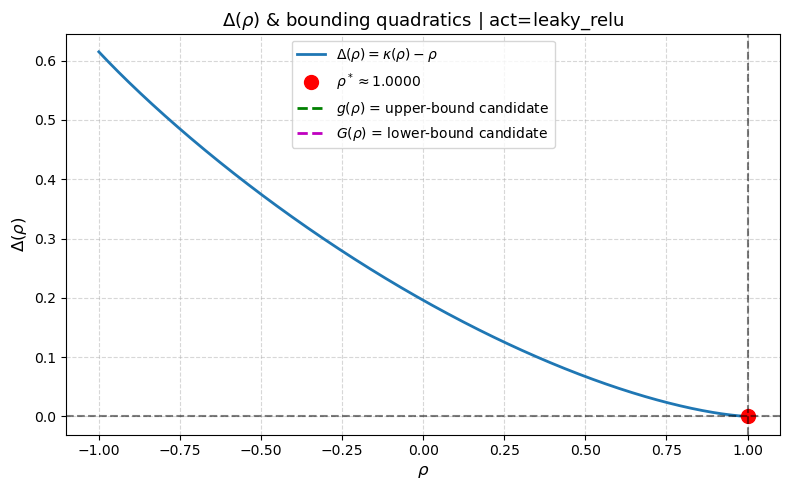

[leaky_relu]
   rho_star = 1.000000, Delta(rho_star) = 9.469092e-13 (should be ~0).
   f'(x_0)=-0.0316, f'(x_1)=-0.0316, alpha=0.0316, beta=0.0316



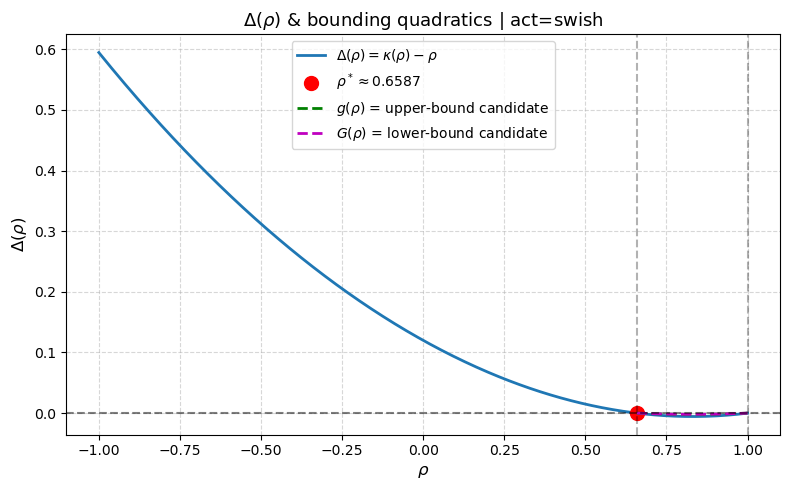

[swish]
   rho_star = 0.658667, Delta(rho_star) = 9.092727e-13 (should be ~0).
   f'(x_0)=-0.0646, f'(x_1)=0.0666, alpha=0.0646, beta=0.0666



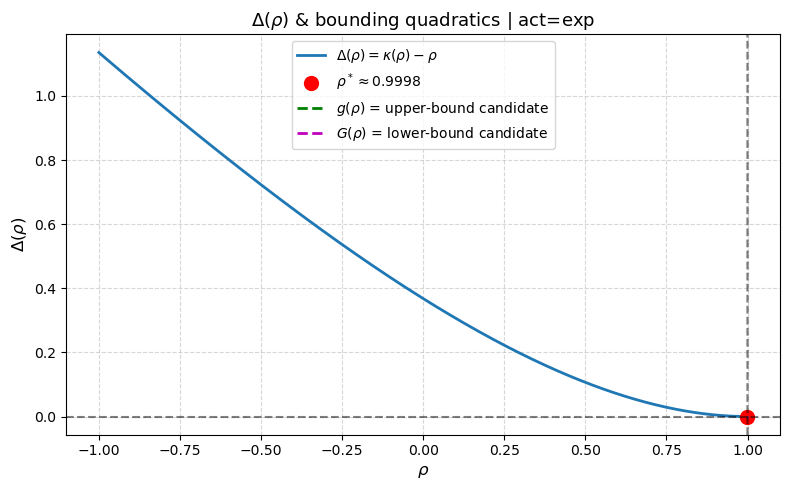

[exp]
   rho_star = 0.999800, Delta(rho_star) = 1.997921e-08 (should be ~0).
   f'(x_0)=-0.0002, f'(x_1)=-0.0000, alpha=0.0000, beta=0.0002



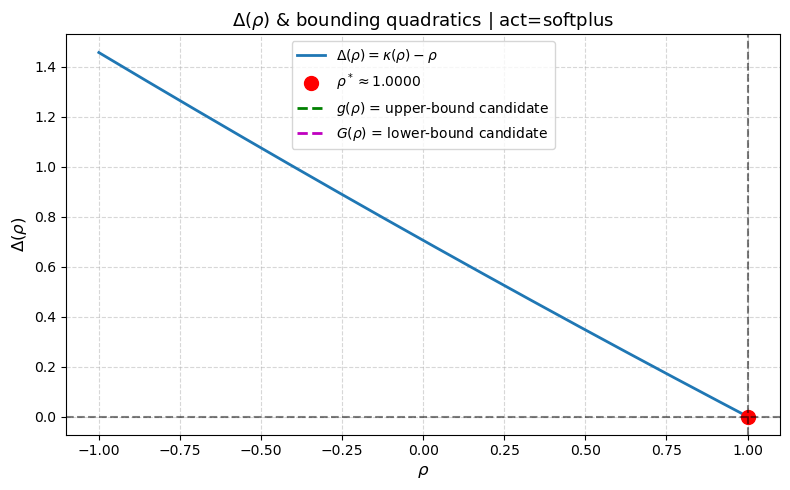

[softplus]
   rho_star = 1.000000, Delta(rho_star) = 2.300382e-13 (should be ~0).
   f'(x_0)=-0.6815, f'(x_1)=-0.6815, alpha=0.6815, beta=0.6815



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import lru_cache
from scipy.integrate import quad
from scipy.special import hermitenorm

###############################################################################
# 1. Activation definitions
###############################################################################
def get_activation_function(name):
    name = name.lower()
    if name == 'relu':
        return lambda x: np.maximum(0, x)
    elif name == 'tanh':
        return np.tanh
    elif name == 'sigmoid':
        return lambda x: 1 / (1 + np.exp(-x))
    elif name == 'gelu':
        return lambda x: 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi)*(x + 0.044715*x**3)))
    elif name == 'elu':
        alpha = 1.0
        return lambda x: np.where(x >= 0, x, alpha*(np.exp(x) - 1))
    elif name == 'selu':
        alpha = 1.6732632423543772
        scale = 1.0507009873554805
        return lambda x: scale * np.where(x >= 0, x, alpha*(np.exp(x) - 1))
    elif name == 'celu':
        alpha = 1.0
        return lambda x: np.where(x >= 0, x, alpha*(np.exp(x/alpha) - 1))
    elif name == 'leaky_relu':
        alpha = 0.2
        return lambda x: np.where(x >= 0, x, alpha*x)
    elif name == 'swish':
        return lambda x: x / (1.0 + np.exp(-x))
    elif name == 'exp':
        return np.exp
    elif name == 'softplus':
        return lambda x: np.log1p(np.exp(x))
    else:
        raise ValueError(f"Unknown or unimplemented activation: '{name}'")

###############################################################################
# 2. Hermite expansion + kernel map
###############################################################################
@lru_cache(maxsize=512)
def gaussian_pdf(x):
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)

def compute_hermite_coefs_integration(f, order=25, a=-10, b=10):
    """
    Numerically compute Hermite coefficients for function f
    in the normalized (physicist) Hermite basis.
    """
    def he_k_normed(x, k):
        return hermitenorm(k)(x) / math.sqrt(math.factorial(k))
    
    coefs = np.zeros(order, dtype=np.float64)
    for k in range(order):
        def integrand(xx):
            return f(xx) * he_k_normed(xx, k) * gaussian_pdf(xx)
        val, _ = quad(integrand, a, b, limit=200)
        coefs[k] = val
    return coefs

def kernel_map_from_coefs(coefs):
    """
    Return kappa(rho) = sum_{k=0}^{K-1} c_k^2 * rho^k
    for the truncated series from len(coefs).
    """
    sq_coefs = coefs**2
    K = len(coefs)
    def kappa(rho):
        val = 0.0
        power = 1.0
        for k in range(K):
            if k==0:
                val += sq_coefs[0]
            else:
                power = rho**k
                val += sq_coefs[k] * power
        return val
    return kappa

###############################################################################
# 3. Finding + plotting the function Delta(rho) = kappa(rho) - rho
###############################################################################
def find_fixed_point(kappa, rho0=0.0, tol=1e-12, maxiter=10000):
    """
    Return stable fixed point by iteration:
      rho_{n+1} = kappa(rho_n).
    """
    rho_curr = rho0
    for i in range(maxiter):
        rho_next = kappa(rho_curr)
        if abs(rho_next - rho_curr) < tol:
            return rho_next
        rho_curr = rho_next
    return rho_curr

def derivative_map(coefs):
    """
    Return f'(rho) where f(rho) = kappa(rho)-rho.
    That is f'(rho) = kappa'(rho) - 1.
    
    kappa'(rho) = sum_{k=1} (k * c_k^2) rho^{k-1}.
    """
    sq_coefs = coefs**2
    K = len(coefs)
    def fprime(rho):
        val = 0.0
        for k in range(1,K):
            val += k * sq_coefs[k] * (rho**(k-1))
        return val - 1.0  # minus derivative of "rho"
    return fprime

def plot_delta_and_bounds(activation_name, order=25):
    """
    For each activation:
      1) Compute kappa(rho).
      2) Plot Delta(rho) = kappa(rho) - rho on [-1,1].
      3) Find stable fixed point rho^* from iteration of kappa, starting at rho=0.
      4) Let x_0 = rho^*, x_1 = 1.
         - define alpha=min(|f'(x_0)|,|f'(x_1)|), beta=max(|f'(x_0)|,|f'(x_1)|)
         - define g(rho)= alpha*(rho-x_0)*(rho-x_1) (upper-bound candidate)
         - define G(rho)= beta*(rho-x_0)*(rho-x_1) (lower-bound candidate)
         - plot them for rho in [x_0, x_1] to see if the hypothesis is visually correct.
    """
    # 1) Activation -> Hermite coefs -> kernel map
    act_f = get_activation_function(activation_name)
    coefs = compute_hermite_coefs_integration(act_f, order=order)
    # normalize so that E[phi^2]=1
    norm_factor = np.sqrt(np.sum(coefs**2))
    if norm_factor>1e-12:
        coefs /= norm_factor
    kappa = kernel_map_from_coefs(coefs)
    
    # 2) define Delta(rho)=kappa(rho)-rho
    def Delta(rho):
        return kappa(rho) - rho
    
    # 3) find stable fixed point in [-1,1], starting from 0
    rho_star = find_fixed_point(kappa, rho0=0.0, tol=1e-12, maxiter=10000)
    
    # 4) Build derivative f'(rho)=Delta'(rho)
    fprime = derivative_map(coefs)  # =>  f'(rho) = kappa'(rho)-1
    
    # We'll only look at [rho_star, 1], provided that rho_star<1
    # If rho_star>1 or < -1, we won't do the bounding.
    x_0 = rho_star
    x_1 = 1.0
    
    # evaluate derivative at x_0, x_1
    fprime_x0 = fprime(x_0)
    fprime_x1 = fprime(x_1)
    alpha = min(abs(fprime_x0), abs(fprime_x1))
    beta  = max(abs(fprime_x0), abs(fprime_x1))
    
    # define the two bounding quadratics
    def g(rho):
        return alpha*(rho - x_0)*(rho - x_1)
    def G(rho):
        return beta*(rho - x_0)*(rho - x_1)
    
    # 5) Plot Delta(rho) on [-1,1]
    rhos = np.linspace(-1,1,501)
    Dvals = [Delta(r) for r in rhos]
    
    # We'll also define a narrower grid for [x_0, x_1] if x_0< x_1
    if x_0 < x_1:
        rhos2 = np.linspace(x_0, x_1, 300)
        gvals  = [g(r) for r in rhos2]
        Gvals  = [G(r) for r in rhos2]
        Dvals2 = [Delta(r) for r in rhos2]
    else:
        rhos2 = []
        gvals = []
        Gvals = []
        Dvals2= []
    
    plt.figure(figsize=(8,5))
    # -- main Delta(rho) plot
    plt.plot(rhos, Dvals, label=r'$\Delta(\rho)=\kappa(\rho)-\rho$', lw=2)
    
    # mark the fixed point
    # if Delta(rho_star)=0, so we plot star at (rho_star,0)
    if -1<=rho_star<=1:
        plt.plot([rho_star],[0], 'o', ms=10, color='red',
                 label=rf'$\rho^*\approx {rho_star:.4f}$')
    
    # plot the bounding quadratics on [x_0,x_1]
    if len(rhos2)>0:
        plt.plot(rhos2, gvals, 'g--', lw=2, label=r'$g(\rho)$ = upper-bound candidate')
        plt.plot(rhos2, Gvals, 'm--', lw=2, label=r'$G(\rho)$ = lower-bound candidate')
    
        # for visual reference
        # We'll also mark x_0, x_1 on x-axis
        plt.axvline(x_0, color='black', ls='--', alpha=0.3)
        plt.axvline(x_1, color='black', ls='--', alpha=0.3)
    
    plt.axhline(0, color='black', ls='--', alpha=0.5)
    plt.xlabel(r'$\rho$', fontsize=12)
    plt.ylabel(r'$\Delta(\rho)$', fontsize=12)
    plt.title(f"$\\Delta(\\rho)$ & bounding quadratics | act={activation_name}", fontsize=13)
    plt.grid(ls='--', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Console info
    print(f"[{activation_name}]")
    print(f"   rho_star = {rho_star:.6f}, Delta(rho_star) = {Delta(rho_star):.6e} (should be ~0).")
    print(f"   f'(x_0)={fprime_x0:.4f}, f'(x_1)={fprime_x1:.4f}, alpha={alpha:.4f}, beta={beta:.4f}\n")

###############################################################################
# 6. Run for multiple activations
###############################################################################
if __name__=='__main__':
    activation_list = [
        "relu", "tanh", "sigmoid", "gelu", "elu", "selu",
        "celu", "leaky_relu", "swish", "exp", "softplus",
    ]
    
    for act in activation_list:
        try:
            plot_delta_and_bounds(act, order=25)
        except Exception as e:
            print(f"[Warning] {act} => {e}")
